In [1]:
%matplotlib inline
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from linearmodels.panel.model import PooledOLS
from linearmodels.asset_pricing.model import LinearFactorModel
from sklearn.metrics import r2_score
import seaborn as sn

In [2]:
ols_model = LinearRegression()

In [3]:
"""
Input Explanation:
df_beta is the dataframe of stock betas obtained by running the first stage of BJS regression  # mat(N*K)
df_f is the dataframe of factor realizations # mat(T*K)
df_return is the dataframe of excess stock returns # mat(T*K)
df_res is the dataframe of residuals obtained by running the first stage of BJS regression # mat(T*N)
"""

def Shanken_lambda(df_betas, df_f, df_return, df_res):
    beta = df_betas #only factor loadings no intercepts; mat(N*K)
    res = df_res
    ret = df_return
    f = np.mat(df_f)
    N = len(beta)
    T = len(df_f)
    K = len((df_f).columns)
    
    X = np.mat(pd.concat([pd.DataFrame({"Cons":np.repeat(1,N)}), beta.reset_index(drop=True)], axis=1))#mat(N*K+1)
    X_mul = np.dot(X.T, X)/N #mat(K+1*K+1)
    
    cov_res = (1/(N*(T-K-1)))*np.diagonal(np.dot(res.T,res)).sum() #a value
    inv_f_mul = np.linalg.inv(np.dot(f.T,f)) #mat(K*K)
    
    mat = cov_res*inv_f_mul #mat(K*K)
    tmp = np.insert(mat, 0, 0, axis=0) #mat(K+1*K)
    mat = np.insert(tmp, 0, 0, axis=1) #mat(K+1*K+1)
    
    X_R = np.dot(X.T, ret.mean())/N #mat(K+1*1)
    
    adj_lam = np.dot(np.linalg.inv(X_mul - mat),X_R.T) #mat(K+1*1)
    return adj_lam

In [4]:
def Shanken_lambda_nocons(df_betas, df_f, df_return, df_res):
    beta = pd.DataFrame(df_betas)
    res = df_res
    ret = df_return
    f = np.mat(df_f)
    N = len(beta)
    T = len(df_f)
    K = len((df_f).columns)
    
    X = np.mat(beta.reset_index(drop=True))#mat(N*K)
    X_mul = np.dot(X.T, X)/N #mat(K*K)
    
    cov_res = (1/(N*(T-K-1)))*np.diagonal(np.dot(res.T,res)).sum() #a value
    inv_f_mul = np.linalg.inv(np.dot(f.T,f)) #mat(K*K)
    
    mat = cov_res*inv_f_mul #mat(K*K)
    
    X_R = np.dot(X.T, ret.mean())/N #mat(K*1)
    
    adj_lam = np.dot(np.linalg.inv(X_mul - mat),X_R.T) #mat(K*1)
    return adj_lam

In [5]:
"""
Input Explanation:
df_beta is the dataframe of stock betas obtained by running the first stage of BJS regression  # mat(N*K)
df_f is the dataframe of factor realizations # mat(T*K)
df_lam is the dataframe of factor risk premiums obtained by running the second stage of BJS regression # mat(T*K)
df_res is the dataframe of residuals obtained by running the first stage of BJS regression # mat(T*N)
"""

def Shanken_tstats(df_betas, df_f, df_lambdas, df_res):
    beta = df_betas
    lam = df_lambdas.iloc[:,1:].mean()
    alpha = df_lambdas.iloc[:,0].mean()
    f = np.mat(df_f.T)
    res = df_res
    T = len(df_f)
    N = len(beta)

    X = np.mat(pd.concat([pd.DataFrame({"Cons":np.repeat(1,N)}), beta.reset_index(drop=True)], axis=1))#mat(N*K+1)
    X_mul = np.dot(np.linalg.inv(np.dot(X.T,X)),X.T) #mat(K+1*N)
    X_rev = np.dot(X,np.linalg.inv(np.dot(X.T,X))) #mat(N*K+1)

    cov_res = res.cov() #mat(N*N)
    X_mul_res = np.dot(np.dot(X_mul, cov_res),X_rev) #mat(K+1*K+1)

    cov_f = np.mat(np.cov(f)) #mat(K*K)
    mat = np.insert(cov_f, 0, 0, axis=0) #mat(K+1*K)
    mat = np.insert(mat, 0, 0, axis=1) #mat(K+1*K+1)

    c = pd.DataFrame(1+np.dot(np.dot(lam,np.linalg.inv(cov_f)),lam.T)) #c is a coefficient 

    adj_cov = (1/T)*(np.multiply(X_mul_res,c.values)+mat) #mat(K+1*K+1)
    se = np.sqrt(np.diagonal(adj_cov)) #arr(K+1)
    t_stats = np.append(alpha, np.array(lam))/se #arr(K+1)

    return t_stats

In [6]:
def R_squared(df_return, cs_resids):
    
    SS_res = np.diagonal(cs_resids.cov()).sum()
    SS_tot = np.diagonal(df_return.cov()).sum()
    R_squared = 1 - (SS_res/SS_tot)
    
    return R_squared

In [7]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [8]:
def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

In [9]:
## Newey-West Adjustment For a Time-Series Data, e.g. Lambdas (factor returns)
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Import Data

In [10]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

Import risk-free rate (91-day T-Bill)

In [11]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [12]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])
df_SR.index = pd.to_datetime(df_SR.index)

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [13]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
df_SR = df_SR.apply(replacer)

Calculate the Excess Stock Returns 

In [14]:
df_Ex_SR = df_SR-df_RF.values

Import the Factor Realizations (Mimicking portfolio returns)

In [15]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)
df_FF3.index = pd.to_datetime(df_FF3.index)

In [16]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)
df_FF4.index = pd.to_datetime(df_FF4.index)

In [17]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)
df_FF5.index = pd.to_datetime(df_FF5.index)

Import Firm Characteristics 

In [18]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size = df_ln_Size.replace([np.inf, -np.inf], np.nan)
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)
df_ln_Size.index = pd.to_datetime(df_ln_Size.index)

In [19]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE = df_PE.replace([np.inf, -np.inf], np.nan)
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)
df_PE.index = pd.to_datetime(df_PE.index)
df_EP = 1/df_PE

In [20]:
df_PB = pd.read_csv('df_PB.csv')
df_PB = df_PB.replace([np.inf, -np.inf], np.nan)
df_PB.Dates = df_PB.Dates.apply(lambda x:x[:10])
df_PB.set_index('Dates',inplace=True)
df_PB.index = pd.to_datetime(df_PB.index)
df_BP = 1/df_PB

In [21]:
df_OP = pd.read_csv('df_std_OP.csv')
df_OP = df_OP.replace([np.inf, -np.inf], np.nan)
df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])
df_OP.set_index('Dates',inplace=True)
df_OP.index = pd.to_datetime(df_OP.index)

In [22]:
df_INV = pd.read_csv('df_std_INV.csv')
df_INV = df_INV.replace([np.inf, -np.inf], np.nan)
df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])
df_INV.set_index('Dates',inplace=True)
df_INV.index = pd.to_datetime(df_INV.index)

# Winsorization

In [23]:
df_Ex_SR = df_Ex_SR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [24]:
df_FF3 = df_FF3.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF4 = df_FF4.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF5 = df_FF5.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_MR = df_MR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [25]:
df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.020678,-0.015547,0.012542,-0.038019,-0.020355,0.003464,-0.024971,-0.046701,-0.041012,-0.009411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.015876,-0.039501,0.066746,-0.000279,-0.000279,0.010867,-0.047144,-0.006779,-0.048165,0.014896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.004951,0.017172,0.066746,0.037465,-0.000275,0.021650,0.013148,0.052647,0.034541,0.041029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040553,0.053297,0.066534,-0.000275,0.026405,-0.037089,0.051113,0.116362,0.050048,0.020698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.078535,0.029097,0.019928,0.014431,0.012802,0.005955,0.051113,0.044575,-0.049104,-0.044641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,NaN,NaN,-0.000308,NaN,-0.000189,NaN,0.004422,NaN,0.003483,0.012353,...,-0.060519,0.007442,-0.003571,-0.009381,0.002857,0.018901,0.015940,-0.003086,0.023825,0.010409


# CAPM

In [26]:
# Keep the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:].dropna(axis=1)
    
betas = []
ts_resids = pd.DataFrame()
for j in df_Ex_SR_trnct.columns:
    lag = int(4*((len(df_Ex_SR.loc[:, j]))/100)**(1/9))
    OLS = sm.OLS(df_Ex_SR_trnct.loc[:,j].values.astype(np.float64), sm.add_constant(df_MR.values.astype(np.float64)))
    res = OLS.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    ts_r = pd.DataFrame(res.resid)
    b = list(res.params)
    b.append(j)
    ts_resids = pd.concat([ts_resids,ts_r], axis=1)
    betas.append(b)
df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept',1:'MKT',2:"stock"}).set_index('stock')

lambdas = []
time = []
cs_resids = pd.DataFrame()
predict = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
for k in tqdm(df_Ex_SR_trnct_T.columns):
    OLS = sm.OLS(df_Ex_SR_trnct_T.loc[:,k].values, sm.add_constant(df_betas["MKT"].astype(np.float64)))
    res = OLS.fit()
    cs_r = pd.DataFrame(res.resid)
    pred = pd.DataFrame(res.predict())
    l = list(res.params)
    cs_resids = pd.concat([cs_resids,cs_r], axis=1)
    predict = pd.concat([predict,pred], axis=1)
    lambdas.append(l)
    time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT'})

100%|██████████| 5215/5215 [01:09<00:00, 74.72it/s] 


In [27]:
df_betas

,Intercept,MKT
stock,,
MTN.SJ.Equity,-0.000164,1.032938
AEG.SJ.Equity,0.002280,0.630997
NTC.SJ.Equity,0.000255,0.575959
WHL.SJ.Equity,0.000057,0.704912
SOL.SJ.Equity,-0.000159,1.114427
...,...,...
SNT.SJ.Equity,0.000187,0.303468
CLH.SJ.Equity,0.000342,0.199378
HDC.SJ.Equity,0.000813,0.210354


In [28]:
df_lambdas

,Intercept,MKT
0,-0.006543,-0.017912
1,-0.002792,-0.003681
2,0.011955,0.018895
3,0.018668,0.015708
4,0.021093,-0.034696
...,...,...
5210,0.004700,-0.004731
5211,0.004700,-0.004731
5212,0.003691,0.000205
5213,0.013048,-0.014593


In [29]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

stock,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
2000-01-05,0.037586,-0.002510,-0.008112,-0.021844,0.017093,0.018906,0.006229,-0.019168,-0.009228,-0.061658,...,0.046777,-0.046476,0.012057,-0.040537,-0.034743,0.011699,0.009835,0.010032,0.020720,-0.000471
2000-01-06,0.073339,0.004835,-0.042232,-0.042779,0.021790,-0.009460,0.030828,-0.013740,0.015864,-0.010262,...,0.039450,0.003632,0.017560,0.003436,0.006620,-0.029159,0.003247,0.003287,-0.019010,0.014854
2000-01-07,0.035274,-0.024152,-0.009689,0.009267,0.008017,-0.018374,0.002489,-0.032624,0.028184,0.009190,...,0.053838,0.021225,0.035243,-0.016969,-0.004912,-0.014638,-0.057884,-0.016204,0.006400,-0.017135
2000-01-10,0.031641,-0.002175,0.023398,0.020307,-0.015475,0.021246,-0.009997,-0.039427,0.023219,-0.012791,...,-0.021375,0.014002,0.039155,-0.022883,0.051027,0.020165,-0.022075,-0.011776,0.031558,-0.023021
2000-01-11,0.034673,0.013602,0.050003,-0.045739,-0.027069,0.014909,-0.001634,-0.020304,-0.057764,-0.007598,...,-0.043025,-0.029554,0.049277,-0.012665,0.062116,0.006498,-0.008649,0.006549,0.005850,-0.012360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.000003,-0.001905,-0.002166,-0.001555,0.000382,-0.000395,-0.000498,0.001279,-0.002295,-0.001765,...,-0.004158,-0.003452,-0.003360,-0.003704,-0.003622,-0.003455,-0.003947,-0.003895,-0.003991,-0.003662
2019-12-26,-0.000003,-0.001905,-0.002166,-0.001555,0.000382,-0.000395,-0.000498,0.001279,-0.002295,-0.001765,...,-0.004158,-0.003452,-0.003360,-0.003704,-0.003622,-0.003455,-0.003947,-0.003895,-0.003991,-0.003662
2019-12-27,-0.004211,-0.004010,0.000613,-0.000352,0.008433,-0.000486,0.000813,0.004874,-0.005465,0.021657,...,-0.003912,-0.006119,-0.003947,0.032836,0.005846,-0.025604,-0.002795,-0.024174,-0.089177,0.009373
2019-12-30,-0.005555,-0.004029,0.006352,0.011005,-0.005479,0.005079,-0.009926,0.016803,-0.003760,0.004107,...,-0.010978,-0.013167,0.033155,-0.050813,-0.033742,0.018585,-0.009632,-0.035248,0.094508,-0.014233


Shanken (1992) Correction

In [30]:
r2_score(df_Ex_SR_trnct,predict.T)

0.14222967300924846

In [31]:
R_squared(df_Ex_SR_trnct, cs_resids)

0.1204953722542208

In [32]:
Shanken_lambda(df_betas.iloc[:,1:], df_MR, df_Ex_SR_trnct, ts_resids)*21*100

matrix([[ 1.41644855],
        [-1.23644467]])

In [33]:
Shanken_tstats(df_betas.iloc[:,1:], df_MR, df_lambdas, ts_resids)

array([ 7.04070152, -2.80265463])

In [34]:
# LinearFactor model does not include intercept in the second step of FM procedure
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=df_Ex_SR.dropna(axis = 1), factors= df_MR, risk_free = None)
res_ols = model_ols.fit()
res_ols

LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 70   R-squared:                      0.0706
No. Factors:                          1   J-statistic:                    186.40
No. Observations:                  5215   P-value                         0.0000
Date:                  Mon, Jun 20 2022   Distribution:                 chi2(69)
Time:                          00:44:07                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0004     0.0002     2.2761     0.0228   5.614e-05      0.0008
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
LinearFactorModelResults, id: 0x7fe045308100

## Added Control Variables_CAPM

In [35]:
# Keep the size and EP have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]
df_EP_trnct = df_EP.loc[df_Ex_SR_trnct.index,:]
df_BP_trnct = df_BP.loc[df_Ex_SR_trnct.index,:]

In [36]:
len(df_ln_Size_trnct)==len(df_EP_trnct)==len(df_Ex_SR_trnct)==len(df_BP_trnct)

True

In [37]:
lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
df_ln_Size_trnct_T = df_ln_Size_trnct.T
df_BP_trnct_T = df_BP_trnct.T

for k in tqdm(df_Ex_SR_trnct_T.columns):
    index_tmp = (df_betas.index).intersection(df_ln_Size_trnct_T.loc[:,k].dropna().index).intersection(df_BP_trnct_T.loc[:,k].dropna().index)
    if len(index_tmp)>=10:
        OLS = sm.OLS(df_Ex_SR_trnct_T.loc[index_tmp,k].values, sm.add_constant(pd.concat([df_betas.loc[index_tmp,"MKT"],df_ln_Size_trnct_T.loc[index_tmp,k], df_BP_trnct_T.loc[index_tmp,k]], axis = 1).astype(np.float64)))
        res = OLS.fit()
        cs_r = pd.DataFrame(res.resid)
        l = list(res.params)
        cs_resids = pd.concat([cs_resids,cs_r], axis=1)
        lambdas.append(l)
        time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT', 2:"Size", 3:"BP"})


100%|██████████| 5215/5215 [00:19<00:00, 273.95it/s]


In [38]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

,MTN.SJ.Equity,AEG.SJ.Equity,WHL.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,ACL.SJ.Equity,MUR.SJ.Equity,AVI.SJ.Equity,DTC.SJ.Equity,BAW.SJ.Equity,...,DRD.SJ.Equity,JSC.SJ.Equity,LBH.SJ.Equity,HAR.SJ.Equity,GFI.SJ.Equity,ANG.SJ.Equity,RMH.SJ.Equity,HYP.SJ.Equity,RDF.SJ.Equity,OCT.SJ.Equity
2000-01-05,0.033973,-0.007194,-0.026085,0.002769,-0.020992,0.027271,0.017806,0.012782,-0.007924,0.017945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.067559,0.006063,-0.043250,0.023916,-0.027061,0.007732,0.033037,-0.004718,-0.016541,-0.003651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.046758,-0.018070,0.016058,-0.007358,-0.030427,0.023637,0.007475,-0.029533,0.001153,-0.025640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.037541,-0.005984,0.018620,-0.025657,-0.037394,-0.001237,0.007256,-0.011836,0.014720,0.026461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.034810,0.008409,-0.048831,-0.008073,-0.016080,-0.018305,0.015819,-0.014892,-0.011881,0.063400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.024305,-0.008229,0.015549,-0.030220,-0.028053,0.002160,-0.013107,0.007052,-0.035671,0.001569,...,0.004884,0.141766,0.020218,-0.004672,-0.027365,-0.009968,0.015780,0.017066,0.013286,-0.002322
2019-12-24,-0.021571,-0.003573,-0.004754,-0.017534,0.043143,-0.007596,0.011244,-0.006736,0.002032,-0.004006,...,0.028928,-0.050815,-0.023396,0.049105,0.038346,0.041978,-0.009112,-0.025217,-0.012409,-0.005406
2019-12-27,-0.006740,0.049634,-0.007297,0.001122,-0.000518,-0.036799,-0.022564,0.007003,-0.006829,0.013242,...,0.019212,-0.001354,0.012541,0.044186,0.017083,0.011996,-0.004372,0.027713,0.007629,0.005738
2019-12-30,-0.005466,-0.020382,0.015212,-0.007093,0.017882,-0.015044,0.009263,0.011950,-0.014711,0.000486,...,-0.026340,0.040197,-0.011581,0.009034,0.009219,0.011340,0.006455,0.000259,0.002205,0.003529


In [39]:
df_lambdas

,Intercept,MKT,Size,BP
0,0.002520,-0.021305,-0.001281,-0.002778
1,-0.022206,0.022031,-0.001118,0.003901
2,-0.019448,0.064733,-0.019855,0.007150
3,0.010122,0.048581,-0.022424,0.001126
4,0.034567,-0.031053,-0.012126,-0.009543
...,...,...,...,...
4990,0.012518,0.004166,-0.021563,-0.003902
4991,0.003108,0.011029,-0.002038,-0.001321
4992,0.012470,0.001752,-0.001106,-0.010179
4993,0.003260,-0.011067,0.001856,0.004025


In [40]:
R_squared(df_Ex_SR_trnct.loc[cs_resids.index,cs_resids.columns], cs_resids)

0.2228526395765501

In [41]:
df_lambdas.mean()*21*100

Intercept    1.223804
MKT          2.197164
Size        -1.650313
BP          -1.145288
dtype: float64

In [42]:
stats.ttest_1samp(df_lambdas, 0)[0]

array([ 4.62065175,  4.10773524, -8.03150437, -6.32402306])

# FF3-Factor Model

In [43]:
# KeBP the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:].dropna(axis=1)

betas = []
ts_resids = pd.DataFrame()
for j in df_Ex_SR_trnct.columns:
    lag = int(4*((len(df_Ex_SR.loc[:, j]))/100)**(1/9))
    OLS = sm.OLS(df_Ex_SR_trnct.loc[:,j].values.astype(np.float64), sm.add_constant(df_FF3.values.astype(np.float64)))
    res = OLS.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    b = list(res.params)
    ts_r = pd.DataFrame(res.resid)
    b.append(j)
    betas.append(b)
    ts_resids = pd.concat([ts_resids,ts_r], axis=1)
df_betas = pd.DataFrame(betas).rename(columns={0:'IntercBPt',1:'MKT',2:"SMB",3:"HML",4:"stock"}).set_index('stock')

lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
for k in tqdm(df_Ex_SR_trnct_T.columns):
    OLS = sm.OLS(df_Ex_SR_trnct_T.loc[:,k].values, sm.add_constant(df_betas.iloc[:,1:4].astype(np.float64)))
    res = OLS.fit()
    cs_r = pd.DataFrame(res.resid)
    l = list(res.params)
    cs_resids = pd.concat([cs_resids,cs_r], axis=1)
    lambdas.append(l)
    time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"IntercBPt", 1:'MKT', 2:"SMB",3:"HML"})


100%|██████████| 4750/4750 [00:31<00:00, 149.51it/s]


In [44]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

stock,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
2000-12-20,-1.977053e-02,-6.102047e-03,3.272034e-02,2.122693e-03,5.020584e-03,2.715910e-02,3.090278e-02,-1.643904e-03,-2.416565e-03,2.311397e-02,...,-9.862113e-03,-5.033309e-03,-7.884818e-03,3.872447e-02,-5.144524e-03,8.853686e-03,-2.760805e-03,1.467836e-03,3.476318e-02,-4.768719e-03
2000-12-21,-9.597859e-03,6.383821e-03,-1.628074e-02,-8.889377e-03,-1.060845e-02,-1.174318e-04,-1.879360e-02,-1.442941e-02,-7.472217e-03,2.278871e-02,...,6.695054e-03,7.839539e-03,1.271677e-02,4.699743e-02,-1.170292e-02,-6.706633e-03,-1.745009e-02,2.451398e-03,-3.876958e-02,-1.771367e-03
2000-12-22,4.534826e-02,-1.324857e-02,-7.321446e-03,1.260755e-02,-3.482766e-02,3.435667e-02,8.484518e-03,2.378834e-03,3.316896e-02,-3.541493e-02,...,-1.196811e-02,-8.420890e-03,7.788732e-02,-4.876377e-02,-2.756059e-03,5.158860e-03,1.803593e-02,-5.569492e-03,2.040359e-02,-6.438104e-03
2000-12-25,1.626303e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.626303e-19,1.084202e-19,1.626303e-19,1.626303e-19,1.084202e-19,1.084202e-19,...,1.084202e-19,1.084202e-19,1.084202e-19,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20,1.084202e-19,5.421011e-20
2000-12-26,1.626303e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.626303e-19,1.084202e-19,1.626303e-19,1.626303e-19,1.084202e-19,1.084202e-19,...,1.084202e-19,1.084202e-19,1.084202e-19,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20,1.084202e-19,5.421011e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-5.821128e-03,-1.405148e-03,-1.669470e-02,-2.521709e-03,1.037446e-02,-1.408473e-02,-1.737867e-02,2.963075e-02,-5.525093e-03,1.686580e-03,...,7.313787e-04,-8.076605e-03,-1.130218e-01,6.223568e-02,2.507874e-02,-1.129706e-02,3.145339e-03,-2.754251e-02,2.968918e-03,7.392437e-03
2019-02-28,-2.078960e-02,2.855665e-01,-5.552826e-03,-1.387691e-02,-2.416783e-03,-8.179769e-03,-1.860128e-02,5.448864e-02,1.801330e-02,-1.538739e-02,...,-5.048285e-02,1.876016e-02,-9.319739e-02,1.638819e-02,-6.573004e-03,2.074107e-02,8.564092e-03,-2.206864e-03,6.212048e-03,-1.427429e-03
2019-03-01,-5.030078e-02,-2.193072e-01,4.326771e-03,4.151535e-03,1.230277e-02,2.778552e-03,4.007626e-02,-3.490069e-02,2.505366e-02,-6.161884e-03,...,5.818979e-02,4.347482e-02,1.263486e-02,3.775837e-03,1.176041e-02,-1.446889e-02,-3.828715e-03,1.217423e-02,9.240357e-03,-1.283405e-02
2019-03-04,-1.923731e-02,-5.897499e-04,1.181691e-02,-3.570692e-03,6.796789e-03,-3.226982e-02,1.015557e-03,2.648449e-02,-4.095879e-03,-1.629013e-02,...,2.584975e-02,-8.341209e-03,-1.157641e-01,7.647673e-04,-1.109384e-02,8.842730e-03,-1.291012e-02,9.509445e-03,1.894513e-02,-2.486832e-02


In [45]:
df_lambdas

,IntercBPt,MKT,SMB,HML
0,0.005882,-7.839427e-03,1.159374e-02,6.427822e-03
1,0.001481,-6.206680e-03,8.682764e-03,-4.212767e-02
2,-0.006677,3.745099e-02,7.867225e-03,1.971060e-02
3,-0.000267,-9.910285e-20,-3.218725e-20,1.694066e-20
4,-0.000267,-9.910285e-20,-3.218725e-20,1.694066e-20
...,...,...,...,...
4745,-0.007518,1.436202e-02,-1.506431e-04,1.878632e-03
4746,-0.007973,1.616103e-02,-8.123676e-03,-1.743644e-02
4747,0.001837,-1.734716e-02,-1.482389e-02,-6.097270e-03
4748,-0.012387,7.717650e-03,-2.367389e-02,3.391055e-02


In [46]:
R_squared(df_Ex_SR_trnct, cs_resids)

0.21370497227673413

In [47]:
Shanken_lambda(df_betas.iloc[:,1:], df_FF3, df_Ex_SR_trnct, ts_resids)*21*100

matrix([[ 1.2424813 ],
        [-0.39190409],
        [ 0.99774157],
        [ 2.47147911]])

In [48]:
Shanken_tstats(df_betas.iloc[:,1:], df_FF3, df_lambdas, ts_resids)

array([ 6.1784248 , -0.94518248,  2.36216324,  3.48904073])

## Added Control Variables_FF3

In [49]:
# KeBP the size and BP have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_EP_trnct = df_EP.loc[df_Ex_SR_trnct.index,:]
df_BP_trnct = df_BP.loc[df_Ex_SR_trnct.index,:]

In [50]:
len(df_ln_Size_trnct)==len(df_BP_trnct)==len(df_Ex_SR_trnct)==len(df_EP_trnct)

True

In [51]:
lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
df_ln_Size_trnct_T = df_ln_Size_trnct.T
df_BP_trnct_T = df_BP_trnct.T

for k in tqdm(df_Ex_SR_trnct_T.columns):
    index_tmp = (df_betas.index).intersection(df_ln_Size_trnct_T.loc[:,k].dropna().index).intersection(df_BP_trnct_T.loc[:,k].dropna().index)
    if len(index_tmp)>=10:
        OLS = sm.OLS(df_Ex_SR_trnct_T.loc[index_tmp,k].values, sm.add_constant(pd.concat([df_betas.loc[index_tmp,["MKT","SMB","HML"]],df_ln_Size_trnct_T.loc[index_tmp,k], df_BP_trnct_T.loc[index_tmp,k]], axis = 1).astype(np.float64)))
        res = OLS.fit()
        cs_r = pd.DataFrame(res.resid)
        l = list(res.params)
        cs_resids = pd.concat([cs_resids,cs_r], axis=1)
        time.append(k)
        lambdas.append(l)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT', 2:"SMB", 3:"HML", 4:"Size", 5:"BP"})


100%|██████████| 4750/4750 [00:20<00:00, 234.73it/s]


In [52]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,ACL.SJ.Equity,SAC.SJ.Equity,MUR.SJ.Equity,...,DRD.SJ.Equity,JSC.SJ.Equity,LBH.SJ.Equity,HAR.SJ.Equity,GFI.SJ.Equity,ANG.SJ.Equity,RMH.SJ.Equity,HYP.SJ.Equity,RDF.SJ.Equity,OCT.SJ.Equity
2000-12-20,-0.019622,0.031358,0.001997,0.002019,0.025800,-0.007541,-0.003113,-0.022565,-0.002030,-0.013273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.010101,-0.014115,-0.006343,-0.004023,-0.007969,0.004421,-0.006804,0.012269,0.018017,0.021000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.047720,-0.007069,0.012145,-0.037148,0.005390,-0.006120,0.030045,0.004172,-0.027990,0.013763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-27,0.038462,0.000098,-0.010806,0.002317,0.027913,-0.012492,0.034546,-0.001876,-0.015060,0.052283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-28,0.005632,-0.014951,0.004840,0.007836,-0.044028,0.019806,-0.010392,-0.026794,-0.017672,-0.076729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.007312,-0.019412,-0.003861,0.008563,-0.020695,0.029825,-0.004239,-0.000365,0.006255,0.014030,...,-0.003633,-0.110405,-0.011994,0.034412,0.001369,0.006844,-0.016457,0.021568,0.004500,0.024757
2019-02-28,-0.014773,0.000446,-0.013313,0.013118,-0.019354,0.049417,0.010293,-0.025305,0.001713,0.001388,...,0.020893,-0.110329,0.003521,-0.028569,-0.019430,-0.017360,-0.001961,-0.022223,-0.007395,0.009702
2019-03-01,-0.052681,-0.000731,0.004964,0.004882,0.032241,-0.031261,0.033088,0.072827,-0.016963,-0.021742,...,-0.024932,0.026837,-0.010744,0.022581,-0.000894,-0.004260,-0.002739,0.041126,-0.004898,-0.007197
2019-03-04,-0.022861,0.009495,-0.002589,-0.004247,0.002833,0.029643,0.001174,0.010929,-0.019724,0.067226,...,0.014758,-0.104299,0.016273,0.001897,-0.012444,-0.035694,-0.035610,0.002950,-0.002649,-0.009327


In [53]:
df_lambdas

,Intercept,MKT,SMB,HML,Size,BP
0,0.011056,-0.002034,0.015331,0.006791,-0.002687,-0.004688
1,-0.001620,-0.018252,0.002959,-0.019210,0.003788,0.003985
2,0.002645,0.027159,0.022099,-0.011416,0.001759,0.000352
3,0.016038,-0.000059,0.011820,-0.042353,0.002833,-0.001729
4,0.022778,-0.002791,0.021358,-0.013633,-0.003346,0.001297
...,...,...,...,...,...,...
4545,-0.002524,0.015455,0.002815,0.006495,-0.000513,-0.003497
4546,-0.017704,0.021317,-0.031331,-0.030679,-0.008124,0.006892
4547,0.013432,-0.011921,0.000113,0.014849,-0.000048,-0.010664
4548,-0.009334,0.005229,-0.008253,0.042237,0.006088,-0.002842


In [54]:
R_squared(df_Ex_SR_trnct.loc[cs_resids.index,cs_resids.columns], cs_resids)

0.290570121545081

In [55]:
df_lambdas.mean()*21*100

Intercept    1.530192
MKT          2.041733
SMB         -1.171354
HML          3.585278
Size        -1.400394
BP          -1.477039
dtype: float64

In [56]:
stats.ttest_1samp(df_lambdas, 0)[0]

array([ 6.49692043,  3.7538534 , -2.29672247,  4.53917586, -6.46008037,
       -8.69918182])

# Carhart4-Factor

In [57]:
df_FF4_tmp = pd.read_csv('df_FF4_tmp.csv')
df_FF4_tmp.Dates = df_FF4_tmp.Dates.apply(lambda x:x[:10])
df_FF4_tmp.set_index('Dates',inplace=True)
df_FF4_tmp.index = pd.to_datetime(df_FF4_tmp.index)
# df_FF4_tmp = df_FF4_tmp.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [58]:
df_FF4["WML"] = df_FF4_tmp["WML"].values

In [59]:
df_FF4

,MR_RF,SMB,HML,WML
Dates,,,,
2000-12-20,-0.0083,0.0065,0.0128,0.0068
2000-12-21,-0.0062,0.0030,-0.0000,-0.0062
2000-12-22,0.0163,-0.0085,-0.0026,-0.0005
2000-12-25,-0.0003,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000
...,...,...,...,...
2019-02-27,0.0008,0.0016,0.0017,-0.0033
2019-02-28,-0.0055,0.0014,-0.0168,-0.0077
2019-03-01,0.0034,-0.0035,0.0113,0.0007


In [60]:
# Keep the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF4.index,:].dropna(axis=1)

betas = []
ts_resids = pd.DataFrame()
for j in df_Ex_SR_trnct.columns:
    lag = int(4*((len(df_Ex_SR.loc[:,j]))/100)**(1/9))
    OLS = sm.OLS(df_Ex_SR_trnct.loc[:,j].values.astype(np.float64), sm.add_constant(df_FF4.values.astype(np.float64)))
    res = OLS.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    ts_r = pd.DataFrame(res.resid)
    b = list(res.params)
    b.append(j)
    ts_resids = pd.concat([ts_resids,ts_r], axis=1)
    betas.append(b)
df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept',1:'MKT',2:"SMB",3:"HML",4:"WML",5:"stock"}).set_index('stock')

lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
for k in tqdm(df_Ex_SR_trnct_T.columns):
    OLS = sm.OLS(df_Ex_SR_trnct_T.loc[:,k].values, sm.add_constant(df_betas.iloc[:,1:5].astype(np.float64)))
    res = OLS.fit()
    cs_r = pd.DataFrame(res.resid)
    l = list(res.params)
    cs_resids = pd.concat([cs_resids,cs_r], axis=1)
    lambdas.append(l)
    time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT', 2:"SMB",3:"HML",4:"WML"})


100%|██████████| 4750/4750 [00:32<00:00, 146.63it/s]


In [61]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

stock,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
2000-12-20,-0.018834,-0.002123,0.033506,-0.000780,0.002303,0.027042,0.029792,-8.556089e-04,0.000996,2.225748e-02,...,-0.010479,-0.003526,-0.012784,0.035998,-0.002374,0.008733,-0.001872,0.001956,0.032236,-0.007807
2000-12-21,-0.010410,0.001319,-0.016658,-0.004667,-0.007959,-0.000131,-0.017901,-1.532710e-02,-0.011352,2.289748e-02,...,0.007626,0.005162,0.019011,0.050240,-0.014900,-0.006708,-0.018223,0.001724,-0.035659,0.001464
2000-12-22,0.046070,-0.011604,-0.006801,0.010931,-0.035478,0.033938,0.008424,3.360516e-03,0.034233,-3.665118e-02,...,-0.010647,-0.008374,0.077426,-0.049704,-0.001378,0.004107,0.018244,-0.005124,0.020326,-0.008167
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.421011e-20,0.000000,-1.626303e-19,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.421011e-20,0.000000,-1.626303e-19,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.006734,-0.007945,-0.017003,0.003042,0.013679,-0.014189,-0.016303,2.859535e-02,-0.010541,1.511727e-03,...,0.002204,-0.011844,-0.104541,0.066433,0.021041,-0.011481,0.002202,-0.028464,0.007107,0.011400
2019-02-28,-0.025020,0.259576,-0.007597,0.007857,0.011391,-0.008182,-0.013936,4.986811e-02,-0.002212,-1.458449e-02,...,-0.045659,0.005020,-0.060528,0.033209,-0.023112,0.020738,0.004486,-0.005890,0.022238,0.015464
2019-03-01,-0.049137,-0.208603,0.004463,-0.004993,0.007028,0.003166,0.038366,-3.353325e-02,0.033231,-4.994379e-03,...,0.054994,0.050241,-0.001989,-0.003094,0.018126,-0.013646,-0.002361,0.013619,0.002080,-0.018926
2019-03-04,-0.020458,-0.005644,0.010817,0.000238,0.010168,-0.032072,0.002351,2.540291e-02,-0.008421,-1.509643e-02,...,0.026443,-0.010241,-0.109658,0.004226,-0.014649,0.009118,-0.014014,0.008861,0.022032,-0.020931


In [62]:
df_betas

,Intercept,MKT,SMB,HML,WML
stock,,,,,
MTN.SJ.Equity,-0.000195,0.843016,-0.548606,0.017240,-0.050381
AEG.SJ.Equity,0.000177,0.613753,-0.288528,0.050406,-0.222732
NTC.SJ.Equity,0.000255,0.433700,-0.428939,0.003174,0.087397
WHL.SJ.Equity,-0.000026,0.466860,-0.644364,-0.092049,0.311195
SOL.SJ.Equity,0.000003,1.128607,-0.014622,-0.028247,-0.154527
...,...,...,...,...,...
SNT.SJ.Equity,0.000147,0.205981,-0.251622,-0.033913,0.125444
CLH.SJ.Equity,0.000405,0.160498,-0.139314,-0.094088,0.051089
HDC.SJ.Equity,0.000714,0.258289,0.093242,0.077345,0.030527


In [63]:
df_lambdas

,Intercept,MKT,SMB,HML,WML
0,0.003183,-9.108841e-04,1.665136e-02,-1.015159e-03,1.554080e-02
1,0.004660,-1.404900e-02,1.644763e-03,-3.302538e-02,-2.028498e-02
2,-0.007635,3.966286e-02,8.990258e-03,1.470479e-02,8.878462e-03
3,-0.000267,-1.948176e-20,-1.185846e-20,-9.529121e-20,-4.404571e-20
4,-0.000267,-1.948176e-20,-1.185846e-20,-9.529121e-20,-4.404571e-20
...,...,...,...,...,...
4745,-0.003424,4.313926e-03,-7.230733e-03,1.344125e-02,-2.589682e-02
4746,0.008497,-2.451508e-02,-3.708324e-02,2.978718e-02,-1.053341e-01
4747,-0.004838,-1.003494e-03,-2.887097e-03,-2.397050e-02,4.319261e-02
4748,-0.008966,-1.015336e-03,-2.833235e-02,4.372413e-02,-2.094767e-02


In [64]:
R_squared(df_Ex_SR_trnct, cs_resids)

0.2401672718612593

In [65]:
Shanken_lambda(df_betas.iloc[:,1:], df_FF4, df_Ex_SR_trnct, ts_resids)*21*100

matrix([[ 0.22302057],
        [ 2.15269526],
        [ 2.87795835],
        [-0.51389208],
        [ 6.38820215]])

In [66]:
Shanken_tstats(df_betas.iloc[:,1:], df_FF4, df_lambdas, ts_resids)

array([2.11619276, 2.69419185, 4.76875618, 0.10948107, 5.41475301])

## Added Control Variables_Carhart4

In [67]:
# KeBP the size and BP have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_EP_trnct = df_EP.loc[df_Ex_SR_trnct.index,:]
df_BP_trnct = df_BP.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [68]:
len(df_ln_Size_trnct)==len(df_BP_trnct)==len(df_Ex_SR_trnct)==len(df_EP_trnct)

True

In [69]:
lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
df_ln_Size_trnct_T = df_ln_Size_trnct.T
df_BP_trnct_T = df_BP_trnct.T

for k in tqdm(df_Ex_SR_trnct_T.columns):
    index_tmp = (df_betas.index).intersection(df_ln_Size_trnct_T.loc[:,k].dropna().index).intersection(df_BP_trnct_T.loc[:,k].dropna().index)
    if len(index_tmp)>=10:
        OLS = sm.OLS(df_Ex_SR_trnct_T.loc[index_tmp,k].values, sm.add_constant(pd.concat([df_betas.loc[index_tmp,["MKT","SMB","HML","WML"]],df_ln_Size_trnct_T.loc[index_tmp,k], df_BP_trnct_T.loc[index_tmp,k]], axis = 1).astype(np.float64)))
        res = OLS.fit()
        cs_r = pd.DataFrame(res.resid)
        l = list(res.params)
        cs_resids = pd.concat([cs_resids,cs_r], axis=1)
        lambdas.append(l)
        time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT', 2:"SMB", 3:"HML", 4:"WML", 5:"Size", 6:"BP"})


100%|██████████| 4750/4750 [00:20<00:00, 229.10it/s]


In [70]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,ACL.SJ.Equity,SAC.SJ.Equity,MUR.SJ.Equity,...,DRD.SJ.Equity,JSC.SJ.Equity,LBH.SJ.Equity,HAR.SJ.Equity,GFI.SJ.Equity,ANG.SJ.Equity,RMH.SJ.Equity,HYP.SJ.Equity,RDF.SJ.Equity,OCT.SJ.Equity
2000-12-20,-0.018875,0.032397,0.001473,0.000345,0.025176,-0.007428,-0.001959,-0.021642,-0.002638,-0.011113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.010985,-0.015719,-0.004082,-0.000560,-0.007346,0.003590,-0.009881,0.010763,0.019009,0.014846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.048210,-0.007065,0.013725,-0.035890,0.004994,-0.006776,0.028446,0.004374,-0.028111,0.010227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-27,0.037405,-0.001668,-0.007507,0.006764,0.028502,-0.013803,0.030268,-0.003386,-0.013850,0.043765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-28,0.011411,-0.009570,-0.010210,-0.004782,-0.045097,0.026449,0.005228,-0.021701,-0.024227,-0.046869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.012504,-0.021176,0.007642,0.005815,-0.016194,0.028912,-0.011577,-0.008753,0.008520,0.001176,...,0.004459,-0.086914,-0.017696,0.026400,0.002051,-0.003685,-0.019467,0.023175,0.005871,0.022215
2019-02-28,-0.025589,-0.003925,0.006331,0.006964,-0.009556,0.047197,-0.002263,-0.038944,0.006577,-0.019847,...,0.034163,-0.070336,-0.005768,-0.043163,-0.015122,-0.034766,-0.006747,-0.018712,-0.005625,0.006238
2019-03-01,-0.049999,0.000343,-0.000546,0.005745,0.029639,-0.030769,0.037063,0.077137,-0.017994,-0.015135,...,-0.029043,0.015049,-0.007932,0.026768,-0.001497,0.000982,-0.001348,0.040372,-0.005594,-0.005906
2019-03-04,-0.027646,0.007603,0.007143,-0.005854,0.007589,0.028822,-0.005916,0.003334,-0.017933,0.055553,...,0.022068,-0.083330,0.011275,-0.005566,-0.011244,-0.044864,-0.038060,0.004201,-0.001527,-0.011632


In [71]:
df_lambdas

,Intercept,MKT,SMB,HML,WML,Size,BP
0,0.010755,-0.000428,0.018779,0.001281,0.005169,-0.002272,-0.004575
1,-0.000401,-0.022096,-0.006420,-0.008355,-0.018085,0.002563,0.003580
2,0.003493,0.025592,0.016582,-0.009090,-0.008082,0.000939,0.000048
3,0.017768,-0.005200,-0.001763,-0.028719,-0.023091,0.001182,-0.002340
4,0.015558,0.016196,0.057758,-0.069299,0.089325,0.001285,0.003635
...,...,...,...,...,...,...,...
4545,0.005949,-0.006946,-0.001085,0.032344,-0.053793,0.004887,-0.003890
4546,-0.003606,-0.019617,-0.036452,0.016405,-0.092052,0.003000,0.006768
4547,0.009176,-0.000143,0.003350,0.002151,0.026334,-0.002741,-0.010560
4548,-0.001910,-0.015739,-0.011425,0.064692,-0.049336,0.010963,-0.002934


In [72]:
R_squared(df_Ex_SR_trnct.loc[cs_resids.index,cs_resids.columns], cs_resids)

0.3210555867977951

In [73]:
df_lambdas.mean()*21*100

Intercept    1.007960
MKT          3.042989
SMB          0.450698
HML          2.051812
WML          4.085277
Size        -1.113894
BP          -1.396303
dtype: float64

In [74]:
stats.ttest_1samp(df_lambdas, 0)[0]

array([ 4.0815679 ,  5.19400917,  0.79840629,  2.53247094,  4.52996251,
       -5.16108159, -8.1749853 ])

# FF5-Factor

In [75]:
# KeBP the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:].dropna(axis=1)

betas = []
ts_resids = pd.DataFrame()
for j in df_Ex_SR_trnct.columns:
    lag = int(4*((len(df_Ex_SR.loc[:, j]))/100)**(1/9))
    OLS = sm.OLS(df_Ex_SR_trnct.loc[:,j].values.astype(np.float64), sm.add_constant(df_FF5.values.astype(np.float64)))
    res = OLS.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    b = list(res.params)
    ts_r = pd.DataFrame(res.resid)
    b.append(j)
    betas.append(b)
    ts_resids = pd.concat([ts_resids,ts_r], axis=1)
df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept',1:'MKT',2:"SMB",3:"HML",4:"RMW",5:"CMA",6:"stock"}).set_index('stock')

lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
for k in tqdm(df_Ex_SR_trnct_T.columns):
    OLS = sm.OLS(df_Ex_SR_trnct_T.loc[:,k].values, sm.add_constant(df_betas.iloc[:,1:6].astype(np.float64)))
    res = OLS.fit()
    cs_r = pd.DataFrame(res.resid)
    l = list(res.params)
    cs_resids = pd.concat([cs_resids,cs_r], axis=1)
    lambdas.append(l)
    time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT', 2:"SMB",3:"HML",4:"RMW",5:"CMA"})


100%|██████████| 4750/4750 [00:34<00:00, 137.52it/s]


In [76]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

stock,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
2000-12-20,-2.231795e-02,-6.907372e-03,3.342545e-02,4.235329e-03,-8.748991e-04,2.566314e-02,2.773390e-02,-4.288597e-03,-1.318584e-03,2.566731e-02,...,-9.702318e-03,-4.829877e-03,-9.831714e-03,3.250377e-02,2.658871e-04,8.711979e-03,-6.891672e-03,-7.289805e-04,3.077680e-02,-5.482243e-03
2000-12-21,-7.191443e-03,1.185661e-02,-1.751666e-02,-1.477079e-02,-5.378783e-03,2.528824e-04,-1.456570e-02,-1.034125e-02,-7.446031e-03,1.681055e-02,...,7.088404e-03,7.404418e-03,1.424115e-02,5.244333e-02,-2.017727e-02,-6.286803e-03,-1.176955e-02,3.751571e-03,-3.249368e-02,-5.737368e-04
2000-12-22,4.203000e-02,-9.296989e-03,-7.683434e-03,9.947827e-03,-4.096662e-02,3.131442e-02,6.903069e-03,1.244636e-03,3.476821e-02,-3.542101e-02,...,-9.938790e-03,-7.850498e-03,7.637694e-02,-5.648456e-02,3.514543e-04,4.531362e-03,1.413876e-02,-8.673629e-03,1.902791e-02,-6.476632e-03
2000-12-25,2.710505e-19,2.168404e-19,2.168404e-19,2.710505e-19,2.710505e-19,2.710505e-19,2.168404e-19,2.710505e-19,2.168404e-19,2.168404e-19,...,1.626303e-19,2.168404e-19,2.168404e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19
2000-12-26,2.710505e-19,2.168404e-19,2.168404e-19,2.710505e-19,2.710505e-19,2.710505e-19,2.168404e-19,2.710505e-19,2.168404e-19,2.168404e-19,...,1.626303e-19,2.168404e-19,2.168404e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19,1.626303e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.995530e-03,-4.945735e-03,-1.592433e-02,-4.021609e-04,1.676543e-02,-1.167857e-02,-1.536719e-02,3.172724e-02,-7.393676e-03,-3.237920e-04,...,5.922959e-04,-9.915560e-03,-1.093568e-01,7.026163e-02,2.154877e-02,-1.175343e-02,7.328479e-03,-2.440151e-02,5.979488e-03,6.953943e-03
2019-02-28,-1.035719e-02,2.556013e-01,3.474454e-04,1.047475e-02,1.316781e-02,2.256596e-03,-2.033232e-02,5.268215e-02,9.718105e-03,-7.265201e-03,...,-5.371922e-02,1.319521e-02,-8.272308e-02,3.830995e-02,-7.300573e-04,1.860010e-02,1.250649e-02,8.570772e-03,2.521709e-03,-5.792825e-03
2019-03-01,-5.646934e-02,-2.046774e-01,8.860317e-04,-7.653939e-03,3.740617e-03,-2.136917e-03,4.036470e-02,-3.515420e-02,2.943568e-02,-7.809163e-03,...,5.836404e-02,4.767312e-02,5.328517e-03,-8.368291e-03,9.956699e-03,-1.256368e-02,-6.842496e-03,6.487532e-03,9.226603e-03,-1.020303e-02
2019-03-04,-1.915027e-02,-7.883500e-03,1.283216e-02,2.718951e-03,7.066742e-03,-3.057393e-02,-1.100762e-03,2.393248e-02,-5.528156e-03,-1.092124e-02,...,2.461101e-02,-8.074816e-03,-1.156278e-01,1.461091e-03,-5.995550e-03,8.637023e-03,-1.540028e-02,1.064744e-02,1.486694e-02,-2.572293e-02


In [77]:
df_betas

,Intercept,MKT,SMB,HML,RMW,CMA
stock,,,,,,
MTN.SJ.Equity,-0.000245,0.851625,-0.518688,0.002255,0.128786,-0.007458
AEG.SJ.Equity,0.000116,0.579894,-0.310462,0.099850,-0.287030,-0.086878
NTC.SJ.Equity,0.000282,0.445562,-0.422164,-0.012408,0.089561,0.017254
WHL.SJ.Equity,0.000087,0.501564,-0.639990,-0.139923,0.247230,0.102285
SOL.SJ.Equity,-0.000069,1.118213,-0.010251,-0.025637,-0.000688,0.059196
...,...,...,...,...,...,...
SNT.SJ.Equity,0.000207,0.213615,-0.261003,-0.039882,0.011560,0.004415
CLH.SJ.Equity,0.000407,0.174014,-0.118397,-0.110223,0.116483,-0.021726
HDC.SJ.Equity,0.000709,0.268894,0.109416,0.061450,0.108455,0.011463


In [78]:
df_lambdas

,Intercept,MKT,SMB,HML,RMW,CMA
0,0.005909,-7.421987e-04,2.054010e-02,-1.282117e-02,8.222713e-03,-4.179213e-02
1,0.000825,-1.384386e-02,-3.206850e-03,-1.378425e-02,-7.361763e-03,7.655234e-02
2,-0.006883,4.353116e-02,1.493087e-02,4.711322e-03,1.676269e-02,-1.366542e-02
3,-0.000267,-8.809143e-20,5.759824e-20,-1.524659e-20,-7.453890e-20,-1.355253e-19
4,-0.000267,-8.809143e-20,5.759824e-20,-1.524659e-20,-7.453890e-20,-1.355253e-19
...,...,...,...,...,...,...
4745,-0.007139,7.303653e-03,-8.542697e-03,1.723965e-02,-1.860895e-02,2.364685e-02
4746,-0.004686,4.297011e-03,-1.909283e-02,-2.091687e-02,-7.949821e-02,-9.926606e-02
4747,0.000122,-9.855231e-03,-7.113158e-03,-7.853856e-03,4.267574e-02,3.403346e-02
4748,-0.011526,9.465007e-03,-1.871987e-02,1.912324e-02,-3.783346e-03,-5.669455e-02


In [79]:
R_squared(df_Ex_SR_trnct, cs_resids)

0.26439520532711003

In [80]:
Shanken_lambda(df_betas.iloc[:,1:], df_FF5, df_Ex_SR_trnct, ts_resids)*21*100

matrix([[ 1.18844595],
        [-0.67374043],
        [ 0.60067959],
        [ 3.86912709],
        [ 0.83204032],
        [ 4.91806487]])

In [81]:
Shanken_tstats(df_betas.iloc[:,1:], df_FF5, df_lambdas, ts_resids)

array([ 5.87883761, -1.36127676,  1.53398041,  3.89998819,  0.64586018,
        2.75312504])

In [82]:
# LinearFactor model does not include intercBPt in the second stBP of FM procedure
model_ols = LinearFactorModel(portfolios=df_Ex_SR.loc[df_FF5.index,:].dropna(axis = 1), factors= df_FF5, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 73   R-squared:                      0.0982
No. Factors:                          5   J-statistic:                    142.57
No. Observations:                  4750   P-value                         0.0000
Date:                  Mon, Jun 20 2022   Distribution:                 chi2(68)
Time:                          00:46:47                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0006     0.0002     2.6804     0.0074      0.0002      0.0011
SMB            0.0002     0.0003     0.8767     0.3807     -0.0003      0.0008
HML            0.0019     0.0005     3.5611     0.0004      0.0008      0.0029
RMW            0.0004     0.0006     0.6437     0.5198     -0.0008      0.0016
CMA            0.0018     0.0011     1.6903     0.0910     -0.0003      0.0039
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

## Added Control Variables_FF5

In [83]:
# KeBP the size and BP have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_BP_trnct = df_BP.loc[df_Ex_SR_trnct.index,:]
df_OP_trnct = df_OP.loc[df_Ex_SR_trnct.index,:]
df_INV_trnct = df_INV.loc[df_Ex_SR_trnct.index,:]

In [84]:
len(df_ln_Size_trnct)==len(df_BP_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [85]:
lambdas = []
time = []
cs_resids = pd.DataFrame()
df_Ex_SR_trnct_T = df_Ex_SR_trnct.T
df_ln_Size_trnct_T = df_ln_Size_trnct.T
df_BP_trnct_T = df_BP_trnct.T
df_OP_trnct_T = df_OP_trnct.T
df_INV_trnct_T = df_INV_trnct.T

for k in tqdm(df_Ex_SR_trnct_T.columns):
    index_tmp = (df_betas.index).intersection(df_ln_Size_trnct_T.loc[:,k].dropna().index).intersection(df_BP_trnct_T.loc[:,k].dropna().index).\
    intersection(df_OP_trnct_T.loc[:,k].dropna().index).intersection(df_INV_trnct_T.loc[:,k].dropna().index)
    
    if len(index_tmp)>=10:
        OLS = sm.OLS(df_Ex_SR_trnct_T.loc[index_tmp,k].values, sm.add_constant(pd.concat([df_betas.loc[index_tmp,["MKT","SMB","HML","RMW","CMA"]], \
                                                                                          df_ln_Size_trnct_T.loc[index_tmp,k], df_BP_trnct_T.loc[index_tmp,k],df_OP_trnct_T.loc[index_tmp,k],\
                                                                                         df_INV_trnct_T.loc[index_tmp,k]],axis = 1).astype(np.float64)))
        res = OLS.fit()
        cs_r = pd.DataFrame(res.resid)
        l = list(res.params)
        cs_resids = pd.concat([cs_resids,cs_r], axis=1)
        lambdas.append(l)
        time.append(k)
df_lambdas = pd.DataFrame(lambdas).rename(columns={0:"Intercept", 1:'MKT', 2:"SMB", 3:"HML", 4:"RMW", 5:"CMA", 6:"Size", 7:"BP", 8:"OP", 9:"INV"})


100%|██████████| 4750/4750 [00:23<00:00, 198.51it/s]


In [86]:
cs_resids = cs_resids.T
cs_resids.index = time
cs_resids

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,ACL.SJ.Equity,SAC.SJ.Equity,MUR.SJ.Equity,AVI.SJ.Equity,...,MST.SJ.Equity,JSC.SJ.Equity,DRD.SJ.Equity,HAR.SJ.Equity,GFI.SJ.Equity,ANG.SJ.Equity,HYP.SJ.Equity,RDF.SJ.Equity,OCT.SJ.Equity,RMH.SJ.Equity
2000-12-20,0.001464,0.034878,0.000630,0.033647,0.003136,-0.008891,-0.022936,-0.005442,-0.009493,0.013448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.000351,-0.018910,-0.006922,0.004346,-0.006161,-0.013602,0.010469,0.008732,0.020010,-0.007709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.012809,0.006096,0.008799,0.006352,0.001172,0.031406,-0.000232,-0.013524,0.024093,0.001853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-27,0.005178,0.007921,-0.010978,0.020523,-0.001183,0.029572,-0.002494,-0.026956,0.044171,0.007145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-28,-0.005950,-0.005146,-0.004147,-0.031860,0.025076,-0.015213,-0.025990,-0.001856,-0.058974,0.008982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.003501,-0.018587,0.000907,-0.017103,0.034391,-0.005768,-0.007696,0.000106,0.007675,0.003255,...,0.045926,-0.101591,-0.001296,0.022216,-0.003149,-0.005039,0.015872,-0.003220,0.020071,-0.015457
2019-02-28,-0.008021,0.004595,0.006811,-0.023864,0.046300,0.006001,-0.025704,-0.023672,-0.017054,-0.008840,...,0.010667,-0.102954,0.013458,-0.021735,-0.011306,-0.022824,-0.038101,-0.022088,-0.012523,0.005270
2019-03-01,-0.054901,-0.004928,-0.000686,0.033203,-0.034708,0.035059,0.067582,-0.010009,-0.017280,-0.030460,...,-0.020446,0.024085,-0.025635,0.024468,-0.000953,-0.002166,0.047556,0.001584,-0.001262,0.000545
2019-03-04,-0.019842,0.011433,0.006995,-0.000891,0.027142,-0.003336,0.011121,-0.033165,0.058334,0.000930,...,0.013427,-0.100319,0.000184,0.013893,-0.002546,-0.032375,-0.004469,-0.007819,-0.021428,-0.032361


In [87]:
df_betas

,Intercept,MKT,SMB,HML,RMW,CMA
stock,,,,,,
MTN.SJ.Equity,-0.000245,0.851625,-0.518688,0.002255,0.128786,-0.007458
AEG.SJ.Equity,0.000116,0.579894,-0.310462,0.099850,-0.287030,-0.086878
NTC.SJ.Equity,0.000282,0.445562,-0.422164,-0.012408,0.089561,0.017254
WHL.SJ.Equity,0.000087,0.501564,-0.639990,-0.139923,0.247230,0.102285
SOL.SJ.Equity,-0.000069,1.118213,-0.010251,-0.025637,-0.000688,0.059196
...,...,...,...,...,...,...
SNT.SJ.Equity,0.000207,0.213615,-0.261003,-0.039882,0.011560,0.004415
CLH.SJ.Equity,0.000407,0.174014,-0.118397,-0.110223,0.116483,-0.021726
HDC.SJ.Equity,0.000709,0.268894,0.109416,0.061450,0.108455,0.011463


In [88]:
df_lambdas

,Intercept,MKT,SMB,HML,RMW,CMA,Size,BP,OP,INV
0,0.006626,-0.009370,0.009429,0.027043,0.007675,-0.014224,0.005950,-0.004214,0.001344,-0.007891
1,0.004281,-0.037001,-0.014766,-0.015665,-0.017689,-0.015087,0.004195,0.004407,0.012334,-0.000587
2,-0.011497,0.036365,0.033601,-0.050246,0.022536,-0.011167,0.013685,0.002005,-0.015051,0.001876
3,0.015117,0.001129,0.027161,-0.114899,-0.000927,-0.085813,0.010595,-0.000112,-0.020004,0.002811
4,0.022178,-0.023008,0.030793,-0.036123,0.023064,0.048131,0.012177,0.002397,-0.005503,-0.001820
...,...,...,...,...,...,...,...,...,...,...
4545,0.001073,0.000387,-0.001463,0.023676,-0.029520,0.023198,0.003318,-0.004393,-0.006071,-0.006170
4546,-0.013611,0.016556,-0.034553,-0.037358,-0.057881,-0.097603,-0.008690,0.004907,-0.002214,-0.002070
4547,0.008210,-0.006082,-0.001240,0.018901,0.010654,0.017883,-0.001185,-0.009539,0.020774,0.004657
4548,-0.008415,0.008466,-0.010262,0.038010,-0.019000,-0.058925,0.003480,-0.003210,0.004337,0.010051


In [89]:
R_squared(df_Ex_SR_trnct.loc[cs_resids.index,cs_resids.columns], cs_resids)

0.39341856258134866

In [90]:
df_lambdas.mean()*21*100

Intercept    1.340526
MKT          1.450867
SMB         -1.988984
HML          4.033314
RMW         -1.583128
CMA          5.647104
Size        -1.507286
BP          -1.455481
OP          -0.156415
INV         -1.361715
dtype: float64

In [91]:
stats.ttest_1samp(df_lambdas, 0)[0]

array([ 4.93957132,  2.56520614, -3.50467046,  4.70506009, -1.96466932,
        3.80319201, -6.44944323, -7.71653133, -0.47572689, -1.18855432])

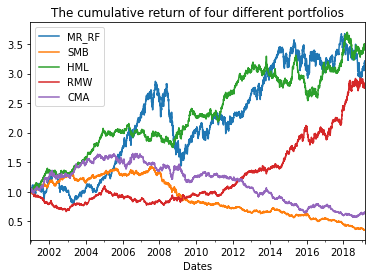

In [92]:
(df_FF5+1).cumprod().plot(title = "The cumulative return of four different portfolios")
plt.show()

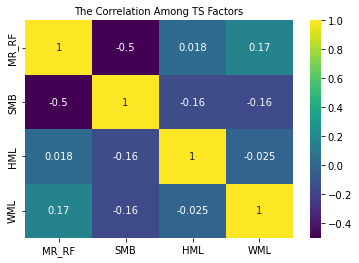

In [93]:
corrMatrix = df_FF4.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()